In [1]:
import pandas as pd
import numpy as np
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
from scipy.interpolate import griddata
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow.keras import layers, models

# get all the data & process it nicely

In [2]:
client = pd.read_csv("../../data/client.csv")
ePrices = pd.read_csv("../../data/electricity_prices.csv")
gasPrices = pd.read_csv("../../data/gas_prices.csv")

weatherPredInt = pd.read_csv("interpolPredWeather.csv")
weatherHistInt = pd.read_csv("interpolHistOverlapWeather.csv")

train = pd.read_csv("../../data/train.csv")

### create features historical weather

In [3]:
# get the diff features
weatherHistInt['cloudcover_total_histint'] = weatherHistInt['cloudcover_total_histint'] / 100
weatherHistInt['surface_solar_radiation_downwards_histint'] = weatherHistInt['diffuse_radiationint'] + weatherHistInt['direct_solar_radiation_histint'] #target['shortwave_radiation']#
weatherHistInt['snowfall_predint'] = 1000/200 * 100 * weatherHistInt['snowfall_predint']
weatherHistInt['10_metre_u_wind_component_histint'] = np.cos(weatherHistInt['winddirection_10mint']) * weatherHistInt['windspeed_10mint']
weatherHistInt['10_metre_v_wind_component_histint'] = np.sin(weatherHistInt['winddirection_10mint']) * weatherHistInt['windspeed_10mint']

weatherHistInt['diff_temperature']                       = abs(weatherHistInt['temperature_predint'] - weatherHistInt['temperature_histint'])#/weatherHistInt['temperature_hist'] #no normalization, otherwise numerical problems when temp close to 0
weatherHistInt['diff_dewpoint']                          = abs(weatherHistInt['dewpoint_predint'] - weatherHistInt['dewpoint_histint'])#/weatherHistInt['dewpoint_hist']
weatherHistInt['diff_cloudcover_total']                  = abs(weatherHistInt['cloudcover_total_predint'] - weatherHistInt['cloudcover_total_histint']) # Cloudcover is already in %!!

#max_dirRad_per_day = weatherHistInt.groupby('Date')['direct_solar_radiation_hist'].transform('max')
weatherHistInt['diff_direct_solar_radiation']            = abs(weatherHistInt['direct_solar_radiation_predint'] - weatherHistInt['direct_solar_radiation_histint'])#/max_dirRad_per_day

# normalize over the maximum day value to get rid of seasonal effects
#max_solRad_per_day = weatherHistInt.groupby('Date')['surface_solar_radiation_downwards_hist'].transform('max')
weatherHistInt['diff_surface_solar_radiation_downwards'] = abs(weatherHistInt['surface_solar_radiation_downwardsint'] - weatherHistInt['surface_solar_radiation_downwards_histint'])#/max_solRad_per_day
weatherHistInt['diff_snowfall']                          = abs(weatherHistInt['snowfall_predint'] - weatherHistInt['snowfall_histint'])#/weatherHistInt['snowfall_hist']
weatherHistInt['diff_10_metre_u_wind_component']         = abs(weatherHistInt['10_metre_u_wind_componentint'] - weatherHistInt['10_metre_u_wind_component_histint'])#/(abs(weatherHistInt['10_metre_u_wind_component_hist']))
weatherHistInt['diff_10_metre_v_wind_component']         = abs(weatherHistInt['10_metre_u_wind_componentint'] - weatherHistInt['10_metre_v_wind_component_histint'])#/abs(weatherHistInt['10_metre_v_wind_component_hist'])


In [4]:
histWfeat = [ #'latitude', 'longitude', 
        'County', 'forecast_datetime',
       'hours_ahead', 'data_block_id',# 'origin_datetime',
       #'temperature_predint', 'dewpoint_predint', 
       #'cloudcover_high_predint','cloudcover_low_predint', 'cloudcover_mid_predint',
       #'cloudcover_total_predint', '10_metre_u_wind_componentint',
       #'10_metre_v_wind_componentint', 'direct_solar_radiation_predint',
       #'surface_solar_radiation_downwardsint', 'snowfall_predint',
       #'total_precipitationint', 'temperature_histint', 'dewpoint_histint',
       #'rainint', 'snowfall_histint', 'surface_pressureint',
       #'cloudcover_total_histint', 'cloudcover_low_histint',
       #'cloudcover_mid_histint', 'cloudcover_high_histint', 'windspeed_10mint',
       #'winddirection_10mint', 'shortwave_radiationint',
       #'direct_solar_radiation_histint', 'diffuse_radiationint',
       #'surface_solar_radiation_downwards_histint',
       #'10_metre_u_wind_component_histint',
       #'10_metre_v_wind_component_histint', 'diff_temperature',
       'diff_dewpoint', 'diff_cloudcover_total', 'diff_direct_solar_radiation',
       'diff_surface_solar_radiation_downwards', 'diff_snowfall',
       'diff_10_metre_u_wind_component', 'diff_10_metre_v_wind_component']
#drop unimportant features
weatherHistInt2 = weatherHistInt[histWfeat]

### add sunlight feature to pred weather
- TODO: we can add a relative sun power downwards normalized over minutes of max sunshine

In [5]:
from datetime import datetime
from suntime import Sun
import pytz

In [6]:
weatherPredInt.head(2)

,Unnamed: 0,latitude,longitude,County,forecast_datetime,hours_ahead,data_block_id,origin_datetime,temperatureint,dewpointint,cloudcover_highint,cloudcover_lowint,cloudcover_midint,cloudcover_totalint,10_metre_u_wind_componentint,10_metre_v_wind_componentint,direct_solar_radiationint,surface_solar_radiation_downwardsint,snowfallint,total_precipitationint
0,0,59.310926,24.924348,0,2021-09-02 00:00:00+00:00,24,1,2021-09-01 00:00:00+00:00,10.067237,5.037243,0.0,0.121643,0.028473,0.127933,1.727094,-4.232588,0.0,0.0,0.0,0.000001
1,1,58.893253,22.618680,1,2021-09-02 00:00:00+00:00,24,1,2021-09-01 00:00:00+00:00,12.167244,5.159730,0.0,0.049673,0.139698,0.157873,1.119604,-7.190296,0.0,0.0,0.0,0.000008


In [7]:
sunrise = []
sunset = []
for i in range(0,weatherPredInt.shape[0]):
    sun = Sun(weatherPredInt.latitude.iloc[i], weatherPredInt.longitude.iloc[i])
    dt = pd.to_datetime(weatherPredInt.forecast_datetime.iloc[i])
    sunrise.append(sun.get_sunrise_time(dt))
    sunset.append(sun.get_sunset_time(dt))

In [8]:
weatherPredInt['sunrise'] = sunrise
weatherPredInt['sunset'] = sunset

In [9]:
weatherPredInt['forecast_datetime'] = pd.to_datetime(weatherPredInt['forecast_datetime'])
def is_daylight(row):
    sunrise = row['sunrise']
    sunset = row['sunset']
    datetime = row['forecast_datetime']
    return sunrise <= datetime <= sunset
def calc_daylight(row):
    sunrise = row['sunrise']
    sunset = row['sunset']
    return (sunset-sunrise).total_seconds()/60
weatherPredInt['daylight'] = weatherPredInt.apply(is_daylight, axis=1)
weatherPredInt['minDaylight'] = weatherPredInt.apply(calc_daylight, axis=1)


In [12]:
weatherPredInt.loc[(weatherPredInt.County == 0) & (weatherPredInt.data_block_id == 424)]
#forecast datetime must be estonian time, otherwise sunrise data does not make sense
# 424 daylight saving
# 207 daylight saving

,Unnamed: 0,latitude,longitude,County,forecast_datetime,hours_ahead,data_block_id,origin_datetime,temperatureint,dewpointint,...,10_metre_u_wind_componentint,10_metre_v_wind_componentint,direct_solar_radiationint,surface_solar_radiation_downwardsint,snowfallint,total_precipitationint,sunrise,sunset,daylight,minDaylight
162432,0,59.310926,24.924348,0,2022-10-30 00:00:00+00:00,24,424,2022-10-29 00:00:00+00:00,6.679505,-0.175324,...,5.670720,-3.086034,0.000000,0.000000,0.0,0.000000,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,False,539.0
162448,0,59.310926,24.924348,0,2022-10-30 01:00:00+00:00,25,424,2022-10-29 00:00:00+00:00,6.493653,-0.043421,...,5.597190,-2.951947,0.000000,0.000000,0.0,0.000000,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,False,539.0
162464,0,59.310926,24.924348,0,2022-10-30 02:00:00+00:00,26,424,2022-10-29 00:00:00+00:00,6.312163,0.000790,...,5.487021,-3.153592,0.000000,0.000000,0.0,0.000000,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,False,539.0
162480,0,59.310926,24.924348,0,2022-10-30 03:00:00+00:00,27,424,2022-10-29 00:00:00+00:00,6.051962,0.167396,...,5.166680,-3.296690,0.000000,0.000000,0.0,0.000000,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,False,539.0
162496,0,59.310926,24.924348,0,2022-10-30 04:00:00+00:00,28,424,2022-10-29 00:00:00+00:00,5.845402,0.125273,...,4.676378,-3.640740,0.000000,0.000000,0.0,0.000000,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,False,539.0
162512,0,59.310926,24.924348,0,2022-10-30 05:00:00+00:00,29,424,2022-10-29 00:00:00+00:00,5.711615,-0.281072,...,4.125960,-3.981750,0.000000,0.000000,0.0,0.000000,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,False,539.0
162528,0,59.310926,24.924348,0,2022-10-30 06:00:00+00:00,30,424,2022-10-29 00:00:00+00:00,5.443586,-1.048114,...,3.602005,-3.892240,2.989662,2.189220,0.0,0.000000,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,True,539.0
162544,0,59.310926,24.924348,0,2022-10-30 07:00:00+00:00,31,424,2022-10-29 00:00:00+00:00,5.526534,-1.113732,...,3.556307,-3.645957,122.088925,48.954242,0.0,-0.000002,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,True,539.0
162560,0,59.310926,24.924348,0,2022-10-30 08:00:00+00:00,32,424,2022-10-29 00:00:00+00:00,5.998935,-1.017925,...,3.847304,-3.771695,152.500031,109.085430,0.0,0.000000,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,True,539.0
162576,0,59.310926,24.924348,0,2022-10-30 09:00:00+00:00,33,424,2022-10-29 00:00:00+00:00,6.268934,-1.355981,...,4.118762,-4.392338,145.718011,150.901460,0.0,0.000000,2022-10-30 05:34:00+00:00,2022-10-30 14:33:00+00:00,True,539.0


### merge train and client

In [13]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

(1009176, 10)


In [14]:
clientsTime = pd.merge(train, client, on=['county','is_business','product_type','data_block_id'], how='inner')
#clientsTime.dropna(inplace=True)

In [15]:
clientsTime['datetime'] = pd.to_datetime(clientsTime['datetime'])
clientsTime['yearday'] = clientsTime['datetime'].dt.day_of_year
clientsTime['weekday'] = clientsTime['datetime'].dt.day_of_week
clientsTime['month'] = clientsTime['datetime'].dt.month

In [16]:
unique_pairs = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
clientsTime['business_prodType'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'])))

unique_pairs_cust = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
clientsTime['ind_customer_id'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))

### interpolate daylight saving nans in client data

for daylight saving (march & october) the dataframe has targets with na
- weather seems to be in estonian time!! (otherwise sunlight exposure would not fit sunrise/sunset)
- weather seems to not care about daylight saving
- client does not double use the data when clocks are turned back (consumption is not the one of 2h)
- ignore day light saving effects & simply interpolate the missing targets

In [18]:
clientsTime = clientsTime.interpolate()

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_11478/4193188307.py:1: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [19]:
(clientsTime.isna() == True).any()

county                False
is_business           False
product_type          False
target_prod           False
datetime              False
data_block_id         False
row_id_prod           False
prediction_unit_id    False
target_cons           False
row_id_cons           False
eic_count             False
installed_capacity    False
date                  False
yearday               False
weekday               False
month                 False
business_prodType     False
ind_customer_id       False
dtype: bool

In [20]:
#nan values when time change!!
clientsTime.loc[clientsTime.target_prod.isna()].datetime.value_counts()
#TODO: weather is in UCT, ePrices & clients not! -> need to deal with time difference!!
# nans for day light savings in ePrices & clients
# weatherInt is wrong!!!! the overlap to the time is different depending on the time difference!!!

Series([], Name: count, dtype: int64)

In [21]:
clientsTime.loc[(clientsTime.county == 1) & (clientsTime.data_block_id == 424) &(clientsTime.prediction_unit_id == 7)]#.interpolate()
#207 spring day light saving, clocks turned forward (skipped 3-4 am)
#424 autum daylight saving, clocks turned backwards (3-4 twice)

,county,is_business,product_type,target_prod,datetime,data_block_id,row_id_prod,prediction_unit_id,target_cons,row_id_cons,eic_count,installed_capacity,date,yearday,weekday,month,business_prodType,ind_customer_id
662568,1,0,3,1.7840,2022-10-30 00:00:00,424,1332064,7,61.463,1332065,63,611.48,2022-10-28,303,6,10,3,1419
662569,1,0,3,1.7040,2022-10-30 01:00:00,424,1332200,7,50.777,1332201,63,611.48,2022-10-28,303,6,10,3,1419
662570,1,0,3,1.6450,2022-10-30 02:00:00,424,1332336,7,49.478,1332337,63,611.48,2022-10-28,303,6,10,3,1419
662571,1,0,3,1.6325,2022-10-30 03:00:00,424,1332472,7,48.311,1332473,63,611.48,2022-10-28,303,6,10,3,1419
662572,1,0,3,1.6200,2022-10-30 04:00:00,424,1332608,7,47.144,1332609,63,611.48,2022-10-28,303,6,10,3,1419
662573,1,0,3,1.6070,2022-10-30 05:00:00,424,1332744,7,48.897,1332745,63,611.48,2022-10-28,303,6,10,3,1419
662574,1,0,3,1.5000,2022-10-30 06:00:00,424,1332880,7,45.375,1332881,63,611.48,2022-10-28,303,6,10,3,1419
662575,1,0,3,1.5350,2022-10-30 07:00:00,424,1333016,7,54.065,1333017,63,611.48,2022-10-28,303,6,10,3,1419
662576,1,0,3,4.4380,2022-10-30 08:00:00,424,1333152,7,52.220,1333153,63,611.48,2022-10-28,303,6,10,3,1419
662577,1,0,3,20.2540,2022-10-30 09:00:00,424,1333288,7,49.767,1333289,63,611.48,2022-10-28,303,6,10,3,1419


### check ePrices for daylight savings errors

In [33]:
ePrices.data_block_id.value_counts()

data_block_id
1      24
428    24
421    24
422    24
423    24
       ..
215    24
216    24
637    24
208    23
572    23
Name: count, Length: 637, dtype: int64

In [46]:
ePrices = ePrices.reset_index()#.head(2)

In [47]:
ePrices['forecast_date'] = pd.to_datetime(ePrices['forecast_date'])

# Set 'timestamp' as the index
ePrices.set_index('forecast_date', inplace=True)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_11478/2052008978.py:10: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [48]:
ePrices.loc[ePrices.data_block_id == 208]

,euros_per_mwh,origin_date,data_block_id
forecast_date,,,
2022-03-27 00:00:00,56.960,2022-03-26 00:00:00,208.0
2022-03-27 01:00:00,53.120,2022-03-26 01:00:00,208.0
2022-03-27 02:00:00,76.595,NaN,208.0
2022-03-27 03:00:00,100.070,2022-03-26 03:00:00,208.0
2022-03-27 04:00:00,47.040,2022-03-26 04:00:00,208.0
2022-03-27 05:00:00,49.170,2022-03-26 05:00:00,208.0
2022-03-27 06:00:00,114.620,2022-03-26 06:00:00,208.0
2022-03-27 07:00:00,100.710,2022-03-26 07:00:00,208.0
2022-03-27 08:00:00,100.920,2022-03-26 08:00:00,208.0


# prepare data into trainable arrays
first axis should be data block id

we will get numpy arrays with daily values of customers, e.g. customer 1 (day 1,2,3,4..), customer 2 (day 1,2,3,4)

### prepare first

In [49]:
#clientsTime, weatherPredInt, weatherHistInt, ePrices, gasPrices

featPredWeather = [
        #'latitude', 'longitude', 
        'County', #'forecast_datetime',
       'hours_ahead',
        'data_block_id', #'origin_datetime', 
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       #'sunrise', 'sunset',
       'daylight', 'minDaylight']

predWeatherComplete = weatherPredInt[featPredWeather]

featHistWeather = [
        'County', #'forecast_datetime',
       'hours_ahead', 'data_block_id',# 'origin_datetime',
       #'temperature_predint', 'dewpoint_predint', 'cloudcover_high_predint',
       #'cloudcover_low_predint', 'cloudcover_mid_predint',
       #'cloudcover_total_predint', '10_metre_u_wind_componentint',
       #'10_metre_v_wind_componentint', 'direct_solar_radiation_predint',
       #'surface_solar_radiation_downwardsint', 'snowfall_predint',
       #'total_precipitationint', 'temperature_histint', 'dewpoint_histint',
       #'rainint', 'snowfall_histint', 'surface_pressureint',
       #'cloudcover_total_histint', 'cloudcover_low_histint',
       #'cloudcover_mid_histint', 'cloudcover_high_histint', 'windspeed_10mint',
       #'winddirection_10mint', 'shortwave_radiationint',
       #'direct_solar_radiation_histint', 'diffuse_radiationint',
       #'surface_solar_radiation_downwards_histint',
       #'10_metre_u_wind_component_histint',
       #'10_metre_v_wind_component_histint', 'diff_temperature',
       'diff_dewpoint', 'diff_cloudcover_total', 'diff_direct_solar_radiation',
       'diff_surface_solar_radiation_downwards', 'diff_snowfall',
       'diff_10_metre_u_wind_component', 'diff_10_metre_v_wind_component'
]
histWeatherComplete = weatherHistInt[featHistWeather]

# can't use client id as an axis in data because it's not constant!
y = np.zeros((clientsTime.shape[0],2))
y_indexes = np.zeros((clientsTime.shape[0],2)) # dataframe indexes in the end, not important for now
index_y = 0

customers = []

constValsArray = np.zeros((1,8))
targetsArray = np.zeros((1,24,2))
ePricesArray = np.zeros((1,24,1))

nFeatHistWeather = histWeatherComplete.shape[1]
histWeatherArray = np.zeros((1,10,nFeatHistWeather))
nFeatPredWeather = predWeatherComplete.shape[1]
predWeatherArray = np.zeros((1,24,nFeatPredWeather))
dataBlockIdArray = np.zeros((1))

# loop over customer, append all data cycles for each customer
for customerId in clientsTime.ind_customer_id.unique():
    customerSlice = clientsTime.loc[clientsTime.ind_customer_id == customerId]

    # const values
    county       = customerSlice.county.unique()[0]
    is_business  = customerSlice.is_business.unique()[0]
    product_type = customerSlice.product_type.unique()[0]
    prediction_unit_id = customerSlice.prediction_unit_id.unique()[0] #should be redundant
    eic_count          = customerSlice.eic_count.unique()[0]
    installed_capacity = customerSlice.installed_capacity.unique()[0]
    yearday = customerSlice.yearday.unique()[0]
    weekday = customerSlice.weekday.unique()[0]
    month   = customerSlice.month.unique()[0]
    business_prodType = customerSlice.business_prodType.unique()[0]
    ind_customer_id   = customerSlice.ind_customer_id.unique()[0]

    customer = {}
    customer['contVals'] = [county, is_business, product_type, prediction_unit_id, eic_count, installed_capacity, business_prodType, ind_customer_id]
    
    for dataBlockId in customerSlice.data_block_id.unique():
        timeSlice = customerSlice.loc[customerSlice.data_block_id == dataBlockId]
        gasSlice = gasPrices.loc[gasPrices.data_block_id == dataBlockId]
        eSlice   = ePrices.loc[ePrices.data_block_id == dataBlockId]

        lowest_price_per_mwh = gasSlice.lowest_price_per_mwh.iloc[0]
        highest_price_per_mwh = gasSlice.highest_price_per_mwh.iloc[0]
        euros_per_mwh = eSlice['euros_per_mwh'].to_numpy()
        if euros_per_mwh.shape[0] == 23:
            print(dataBlockId, customerId)

        y_cons = timeSlice['target_cons'] / installed_capacity
        y_prod = timeSlice['target_prod'] / installed_capacity
        #y[index_y:index_y+24,0] = y_cons
        #y[index_y:index_y+24,1] = y_prod

        #y_indexes[index_y:index_y+24,0] = timeSlice['row_id_cons']
        #y_indexes[index_y:index_y+24,1] = timeSlice['row_id_prod']

        histWeather = histWeatherComplete.loc[(histWeatherComplete.data_block_id == dataBlockId) & (histWeatherComplete.County == county)]
        predWeather = predWeatherComplete.loc[(predWeatherComplete.data_block_id == dataBlockId) & (predWeatherComplete.County == county)]
        #predWeather['ePrices'] = euros_per_mwh
        if y_cons.shape[0] == 23:
            print(dataBlockId, customerId)
        customerDay = {}
        customerDay['y_cons'] = y_cons
        customerDay['y_prod'] = y_prod
        customerDay['ePrices'] = euros_per_mwh
        customerDay['timeBlockConst'] = [lowest_price_per_mwh, highest_price_per_mwh,yearday, weekday, month]
        customerDay['histWeather'] = histWeather
        customerDay['predWeather'] = predWeather
        customer['data_block'] = customerDay

        new_row = np.array([county, is_business, product_type, prediction_unit_id, eic_count, installed_capacity, business_prodType, ind_customer_id])
        constValsArray = np.vstack((constValsArray, new_row))

        new_row = np.zeros((1,24,2))
        new_row[:,:,0] = y_cons
        new_row[:,:,1] = y_prod
        targetsArray = np.concatenate((targetsArray, new_row), axis=0)

        new_row = np.zeros((1,24,1))
        new_row[0,:,0] = euros_per_mwh
        ePricesArray = np.concatenate((ePricesArray, new_row), axis=0)

        new_row = np.zeros((1,10,nFeatHistWeather))
        new_row[:,:,:] = histWeather
        histWeatherArray = np.concatenate((histWeatherArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatPredWeather))
        new_row[:,:,:] = predWeather
        predWeatherArray = np.concatenate((predWeatherArray, new_row), axis=0)

        dataBlockIdArray = np.concatenate((dataBlockIdArray, np.array([dataBlockId])))
    customers.append(customer)

    


In [83]:
#calc absolute targets, not normalized by capacity
targetsAbs = targetsArray.copy()
for ind,instCap in enumerate(constValsArray[:,5]):
    targetsAbs[ind,:] = targetsAbs[ind,:] * instCap

In [51]:
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41870, 24, 2) (41870, 8) (41870, 24, 1) (41870, 10, 10) (41870, 24, 17) (41870,)


In [52]:
np.savez('data_arrays.npz', arr1=targetsArray, arr2=constValsArray, arr3=ePricesArray, arr4 = histWeatherArray, arr5=predWeatherArray, arr6=dataBlockIdArray)

In [63]:
#del client, clientsTime, customerSlice, df_interpolated, df_resampled
#del ePrices,gasPrices,weatherPredInt,weatherHistInt,train

### load data again (if needed)

In [248]:
loaded_data = np.load('data_arrays.npz')

# Access individual arrays by their keys
targetsArray = loaded_data['arr1']
constValsArray = loaded_data['arr2']
ePricesArray = loaded_data['arr3']
histWeatherArray = loaded_data['arr4']
predWeatherArray = loaded_data['arr5']
dataBlockIdArray = loaded_data['arr6']

In [249]:
#remove first rows
targetsArray     = targetsArray[1:,:,:]
constValsArray   = constValsArray[1:,:]
ePricesArray     = ePricesArray[1:,:,:]
histWeatherArray = histWeatherArray[1:,:,:]
predWeatherArray = predWeatherArray[1:,:,:]
dataBlockIdArray = dataBlockIdArray[1:]
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41869, 24, 2) (41869, 8) (41869, 24, 1) (41869, 10, 10) (41869, 24, 17) (41869,)


In [250]:
#calc absolute targets, not normalized by capacity
targetsAbs = targetsArray.copy()
targetsAbs = targetsAbs * constValsArray[:,5].reshape(constValsArray.shape[0],1,1)
print(targetsAbs.shape)

(41869, 24, 2)


# model

In [6]:
tf.random.set_seed(42)

In [ ]:
from sklearn.model_selection import train_test_split

In [16]:
X = [constValsArray,ePricesArray,histWeatherArray,predWeatherArray]
#Y = targetsArray
Y_abs = targetsAbs

In [235]:
np.random.seed(42)
index_array = np.arange(targetsArray.shape[0])
np.random.shuffle(index_array)
arrays = [constValsArray,ePricesArray,histWeatherArray,predWeatherArray,targetsAbs,targetsArray,dataBlockIdArray]
shuffledArr = [arr[index_array] for arr in arrays]
del arrays

In [236]:
trainSplit = int(shuffledArr[4].shape[0]*0.5)
X_train = [shuffledArr[0][0:trainSplit,:],shuffledArr[1][0:trainSplit,:,:],shuffledArr[2][0:trainSplit,:,:],shuffledArr[3][0:trainSplit,:,:]]
y_trainAbs = shuffledArr[4][0:trainSplit,:]
y_train = shuffledArr[5][0:trainSplit,:]

X_test = [shuffledArr[0][trainSplit:-1,:],shuffledArr[1][trainSplit:-1,:,:],shuffledArr[2][trainSplit:-1,:,:],shuffledArr[3][trainSplit:-1,:,:]]
y_testAbs = shuffledArr[4][trainSplit:-1,:]
y_test = shuffledArr[5][trainSplit:-1,:]

In [29]:
trainSplit = int(targetsArray.shape[0]*0.3)
X_train = [constValsArray[0:trainSplit,:],ePricesArray[0:trainSplit,:,:],histWeatherArray[0:trainSplit,:,:],predWeatherArray[0:trainSplit,:,:]]
y_train = targetsArray[0:trainSplit,:]
y_trainAbs = targetsAbs[0:trainSplit,:]

X_test = [constValsArray[trainSplit:-1,:],ePricesArray[trainSplit:-1,:,:],histWeatherArray[trainSplit:-1,:,:],predWeatherArray[trainSplit:-1,:,:]]
y_test = targetsArray[trainSplit:-1,:]
y_testAbs = targetsAbs[trainSplit:-1,:]

### simple neural ned

In [237]:
# Define the inputs
weatherPred_inputs = tf.keras.Input(shape=(24, 17), name='weatherPred_inputs')
ePrices_inputs = tf.keras.Input(shape=(24, 1), name='ePrices_inputs')

weatherHist_input = tf.keras.Input(shape=(10, 10), name='weatherHist_input')
constant_inputs = tf.keras.Input(shape=(8,), name='constant_inputs')

# Process the time-based inputs
weatherPred_flattened = layers.Flatten()(weatherPred_inputs)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
#weatherPred_flattened = layers.Dense(256, activation='relu')(weatherPred_flattened)
#weatherPred_flattened = layers.Dense(64, activation='relu')(weatherPred_flattened)

weatherHist_flattened = layers.Flatten()(weatherHist_input)
weatherHist_flattened = layers.Dense(100, activation='relu')(weatherHist_flattened)
weatherHist_flattened = layers.Dense(100, activation='relu')(weatherHist_flattened)
weatherHist_flattened = layers.Dense(100, activation='relu')(weatherHist_flattened)
#weatherHist_flattened = layers.Dense(64, activation='relu')(weatherHist_flattened)

ePrices_layer = layers.Flatten()(ePrices_inputs)
ePrices_layer = layers.Dense(24, activation='relu')(ePrices_layer)

# Concatenate all inputs
x = layers.Concatenate()([weatherPred_flattened, weatherHist_flattened, ePrices_layer, constant_inputs])

# Main dense block
for i in range(0,5):
    x = layers.Dense(540, activation='relu')(x)
    #x = layers.Dropout(0.1)(x)
#x = layers.Dense(512, activation='relu')(x)
#x = layers.Dense(256, activation='relu')(x)
#x = layers.Dense(540, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
#x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
# = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.1)(x)
#x = layers.Dense(64, activation='relu')(x)

# Output layer for 24*2 targets
output_layer = layers.Dense(24 * 2, activation='linear', name='output')(x)
output_layer = layers.Reshape((24, 2))(output_layer)

def relative_absolute_loss(y_true, y_pred):
    max_values = tf.maximum(tf.abs(y_true), tf.abs(y_pred))
    absolute_loss = tf.abs(y_true - y_pred)
    relative_loss = absolute_loss / (max_values + 1e-8)  # Adding a small epsilon to avoid division by zero

    return tf.reduce_mean(relative_loss)

#normalize over max per day
def relative_absolute_loss(y_true, y_pred):
    max_values = tf.reduce_max(tf.abs(y_true), axis=1, keepdims=True)
    absolute_loss = tf.abs(y_true - y_pred)
    relative_loss = absolute_loss / (max_values + 1e-8)  # Adding a small epsilon to avoid division by zero

    return tf.reduce_mean(relative_loss)

def relative_absolute_loss_elementWise(y_true,y_pred):
        # Calculate the maximum absolute values separately for y_true and y_pred
    max_values_true = tf.reduce_max(tf.abs(y_true), axis=1, keepdims=True)
    max_values_pred = tf.reduce_max(tf.abs(y_pred), axis=1, keepdims=True)
    
    # Calculate the absolute error between prediction and output
    absolute_error = tf.abs(y_true - y_pred)
    
    # Normalize the absolute error over the maximum values for both y_true and y_pred
    normalized_error = absolute_error / (tf.maximum(max_values_true, max_values_pred)+1e-8)  # Using tf.maximum to element-wise choose the maximum
    
    # Calculate the mean loss across the 24x2 values
    mean_loss = tf.reduce_mean(normalized_error, axis=1)
    
    return tf.reduce_mean(mean_loss)*100+tf.keras.losses.mean_absolute_error(y_true,y_pred)#*0.2#+tf.keras.losses.mean_absolute_percentage_error(y_true,y_pred)

In [238]:
model = models.Model(inputs=[constant_inputs,ePrices_inputs, weatherHist_input, weatherPred_inputs], outputs=output_layer)

# Compile the model with an appropriate loss function and optimizer
model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'])

history = model.fit(X_train, y_trainAbs, validation_data=(X_test, y_testAbs), epochs=100, batch_size=1000) #batch size = 110 weather station

Epoch 1/100
21/21 [==============================] - 4s 140ms/step - loss: 198.9502 - mae: 198.9502 - mse: 406588.9688 - val_loss: 162.9628 - val_mae: 162.9628 - val_mse: 234021.9844
Epoch 2/100
21/21 [==============================] - 3s 133ms/step - loss: 142.1379 - mae: 142.1379 - mse: 179330.2188 - val_loss: 121.3858 - val_mae: 121.3858 - val_mse: 116483.2109
Epoch 3/100
21/21 [==============================] - 3s 135ms/step - loss: 115.1957 - mae: 115.1957 - mse: 113029.0859 - val_loss: 112.3041 - val_mae: 112.3041 - val_mse: 108603.6797
Epoch 4/100
21/21 [==============================] - 3s 129ms/step - loss: 102.9400 - mae: 102.9400 - mse: 92755.1953 - val_loss: 99.5468 - val_mae: 99.5468 - val_mse: 83192.9922
Epoch 5/100
21/21 [==============================] - 3s 130ms/step - loss: 95.9916 - mae: 95.9916 - mse: 83345.8984 - val_loss: 97.1846 - val_mae: 97.1846 - val_mse: 81144.0781
Epoch 6/100
21/21 [==============================] - 3s 130ms/step - loss: 94.2749 - mae: 94.27

In [239]:
history = model.fit(X_train, y_trainAbs, validation_data=(X_test, y_testAbs), epochs=100, batch_size=1000) #batch size = 110 weather station

Epoch 1/100
21/21 [==============================] - 3s 149ms/step - loss: 30.5069 - mae: 30.5069 - mse: 11018.2695 - val_loss: 54.1474 - val_mae: 54.1474 - val_mse: 42488.7305
Epoch 2/100
21/21 [==============================] - 3s 145ms/step - loss: 30.4565 - mae: 30.4565 - mse: 10778.5889 - val_loss: 53.8113 - val_mae: 53.8112 - val_mse: 41886.4844
Epoch 3/100
21/21 [==============================] - 3s 148ms/step - loss: 30.0859 - mae: 30.0859 - mse: 10436.5381 - val_loss: 54.2727 - val_mae: 54.2727 - val_mse: 44088.0859
Epoch 4/100
21/21 [==============================] - 3s 145ms/step - loss: 32.9644 - mae: 32.9644 - mse: 13498.1709 - val_loss: 55.7262 - val_mae: 55.7262 - val_mse: 44254.1328
Epoch 5/100
21/21 [==============================] - 3s 145ms/step - loss: 32.3544 - mae: 32.3544 - mse: 12252.7627 - val_loss: 53.9002 - val_mae: 53.9002 - val_mse: 42474.8398
Epoch 6/100
21/21 [==============================] - 3s 146ms/step - loss: 30.0077 - mae: 30.0077 - mse: 10472.0283

In [ ]:
fig = go.Figure()
length = len(history.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [ ]:
a = model.predict(X_test)
predVals = a*X_test[0][:,5].reshape(X_test[0].shape[0],1,1)
print(np.mean(np.abs(y_testAbs - predVals)))
a = model.predict(X_train)
predVals = a*X_train[0][:,5].reshape(X_train[0].shape[0],1,1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs - predVals)))

# reconstruct dataframe and analyze behavior

In [269]:
# restructure dataframes
appendedList = []
shuffledDataBlockId = shuffledArr[6]
for i,data_block_id in enumerate(shuffledDataBlockId):
    isTrain = False
    if i<trainSplit:
        isTrain=True
    
    new_columns = np.zeros((24, 2))  # Adjust the size according to your requirements

    #use targets as first block
    dataBlock = shuffledArr[4][i,:,:].reshape(24,2)

    #add train/test info & data block id
    new_columns = np.ones((24, 2)) * [isTrain, data_block_id]
    dataBlock = np.hstack((dataBlock, new_columns))
    #add const values
    new_columns = np.ones((24, 8)) * shuffledArr[0][i,:].reshape(1,8)
    dataBlock = np.hstack((dataBlock, new_columns))
    #eprices (of yesterday)
    dataBlock = np.hstack((dataBlock, shuffledArr[1][i,:,:].reshape(24,1)))
    # add weather prediction
    dataBlock = np.hstack((dataBlock, shuffledArr[3][i,:,:].reshape(24,17)))

    #hist weather, flatten the array and add all values as columns
    new_columns = np.ones((24, 100)) * shuffledArr[2][i,:].reshape(1,100)
    dataBlock = np.hstack((dataBlock, new_columns))

    appendedList.append(dataBlock)



featPredWeather = [
        #'latitude', 'longitude', 
        'County', #'forecast_datetime',
       'hours_ahead',
        'data_block_id', #'origin_datetime', 
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       #'sunrise', 'sunset',
       'daylight', 'minDaylight']

featHistWeather = [
        'County', #'forecast_datetime',
       'hours_ahead', 'data_block_id',# 'origin_datetime',
       'diff_dewpoint', 'diff_cloudcover_total', 'diff_direct_solar_radiation',
       'diff_surface_solar_radiation_downwards', 'diff_snowfall',
       'diff_10_metre_u_wind_component', 'diff_10_metre_v_wind_component'
]
featConst =['county', 'is_business', 'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity', 'business_prodType', 'ind_customer_id']

feat = ['y_cons','y_prod','isTrain','data_block_id'] + featConst + ['ePrices'] + featPredWeather
for i in range(0,10):
    feat = feat + [f'{value}_'+str(i) for value in featHistWeather]

appendedDf = pd.DataFrame(np.vstack(appendedList), columns=feat)
    
            

add the prediction to the DF

In [271]:
X_train = [shuffledArr[0],shuffledArr[1],shuffledArr[2],shuffledArr[3]]
pred = model.predict(X_train)

1309/1309 [==============================] - 6s 4ms/step


In [272]:
appendedList = []
for i in range(0,pred.shape[0]):
    appendedList.append(pred[i,:,:].reshape(24,2))
predDf = pd.DataFrame(np.vstack(appendedList), columns=['pred_cons','pred_prod'])
appendedDf = pd.concat([appendedDf, predDf], axis = 1)
appendedDf

,y_cons,y_prod,isTrain,data_block_id,county,is_business,product_type,prediction_unit_id,eic_count,installed_capacity,...,data_block_id_9,diff_dewpoint_9,diff_cloudcover_total_9,diff_direct_solar_radiation_9,diff_surface_solar_radiation_downwards_9,diff_snowfall_9,diff_10_metre_u_wind_component_9,diff_10_metre_v_wind_component_9,pred_cons,pred_prod
0,51.669,0.579,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,601.0,3.101161,0.560366,100.622254,109.794506,0.000000,0.356168,7.494485,239.110641,-1.459351
1,45.858,0.652,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,601.0,3.101161,0.560366,100.622254,109.794506,0.000000,0.356168,7.494485,218.549301,2.672261
2,43.995,0.357,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,601.0,3.101161,0.560366,100.622254,109.794506,0.000000,0.356168,7.494485,204.518463,2.169407
3,46.000,0.002,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,601.0,3.101161,0.560366,100.622254,109.794506,0.000000,0.356168,7.494485,199.324326,1.627365
4,51.837,0.000,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,601.0,3.101161,0.560366,100.622254,109.794506,0.000000,0.356168,7.494485,204.542831,0.442297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004851,423.138,6.991,0.0,221.0,13.0,1.0,3.0,52.0,24.0,983.4,...,221.0,2.828235,0.128624,91.261250,22.096357,0.482714,7.197118,3.249779,138.674377,441.209625
1004852,452.994,0.080,0.0,221.0,13.0,1.0,3.0,52.0,24.0,983.4,...,221.0,2.828235,0.128624,91.261250,22.096357,0.482714,7.197118,3.249779,198.631363,133.435440
1004853,428.137,0.000,0.0,221.0,13.0,1.0,3.0,52.0,24.0,983.4,...,221.0,2.828235,0.128624,91.261250,22.096357,0.482714,7.197118,3.249779,261.791962,27.139091
1004854,443.753,0.000,0.0,221.0,13.0,1.0,3.0,52.0,24.0,983.4,...,221.0,2.828235,0.128624,91.261250,22.096357,0.482714,7.197118,3.249779,308.077454,3.903325


# analyze results
- cons error seems gaussian (more or less), abs error up to 2000
    - same for train and test set, ~good generalization
- prod error is weird has quite some peaks that the net seems to not be able to generalize
    - biiig error around 2000
    - same shit error for test and train

In [ ]:
appendedDf = pd.read_csv('appendedDf_simpleNN0.csv')

In [3]:
appendedDf['absErr_cons'] = abs(appendedDf['y_cons']-appendedDf['pred_cons'])
appendedDf['absErr_prod'] = abs(appendedDf['y_prod']-appendedDf['pred_prod'])

<Axes: >

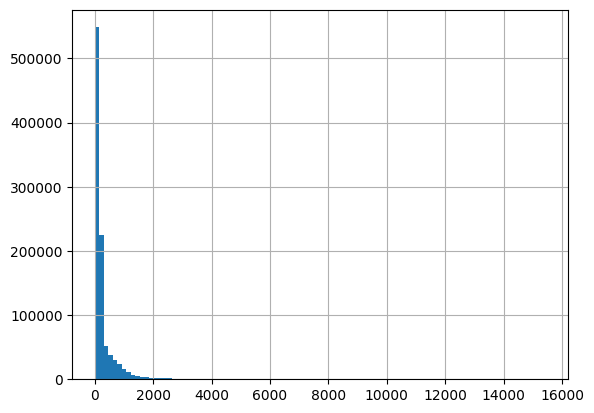

In [11]:
appendedDf.loc[appendedDf.isTrain == 1].absErr_cons.hist(bins=100)

<Axes: >

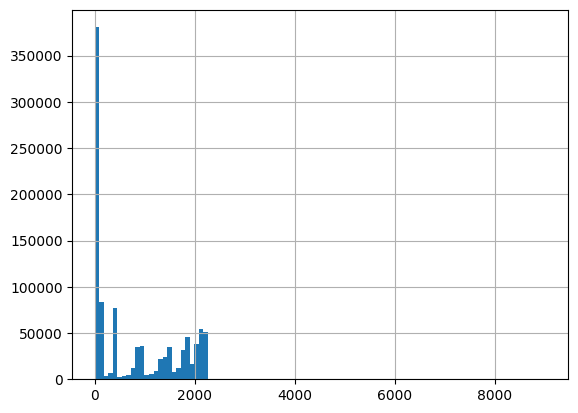

In [14]:
appendedDf.loc[appendedDf.isTrain == 0].absErr_prod.hist(bins=100)

### look at productio error
- it's weird that the error is pretty much exactly the same between test and train, but we see way less train error while training -> maybe wrong df
- CORRECTION: dataframe is random! datablock id & customer id vary greatly

- seems we have more error in the WINTER! (data_block_id+minDaylight shows bigger distribution around winter)
- in general more error in winter (maybe snow??)
- ATTENTTION: add snow height feature!! how much snow has accumulated (historical data!)
    - accumulate over time
    - model how much snow melts with temperatures!! 
    - account for how much snow is getting blown around by storms!
    - if it rains not snows -> snow melts faster, rain is important now!
    -> time based shit, use rnn OR create features (use accumulative function & calculate how much snow melts per hour)

In [11]:
bigErrProd = appendedDf.loc[appendedDf.absErr_prod>2000]

In [8]:
a = appendedDf.iloc[::24]['data_block_id']

In [15]:
#don't consider historical data for now
investigateFeat = ['y_cons','y_prod','isTrain','data_block_id','county','is_business',
'product_type','prediction_unit_id','eic_count','installed_capacity','business_prodType',
'ind_customer_id','ePrices','County','hours_ahead','data_block_id.1',
'temperatureint','dewpointint','cloudcover_highint','cloudcover_lowint','cloudcover_midint',
'cloudcover_totalint','10_metre_u_wind_componentint','10_metre_v_wind_componentint','direct_solar_radiationint',
'surface_solar_radiation_downwardsint','snowfallint','total_precipitationint',
'daylight','minDaylight','pred_cons','pred_prod','absErr_cons','absErr_prod']
bigErrProd = bigErrProd[investigateFeat]

<Axes: xlabel='isTrain'>

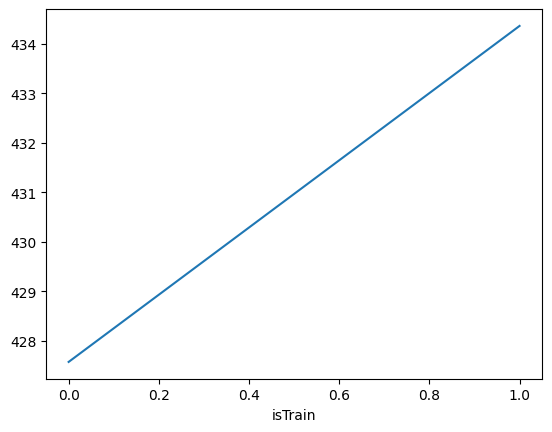

In [32]:
appendedDf.groupby('isTrain')['absErr_cons'].mean().plot()
#-> in general more erro in winter!

<Axes: >

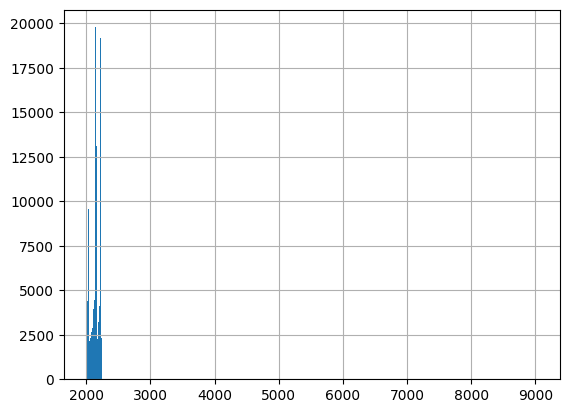

In [34]:
bigErrProd.absErr_prod.hist(bins=700)

<Axes: >

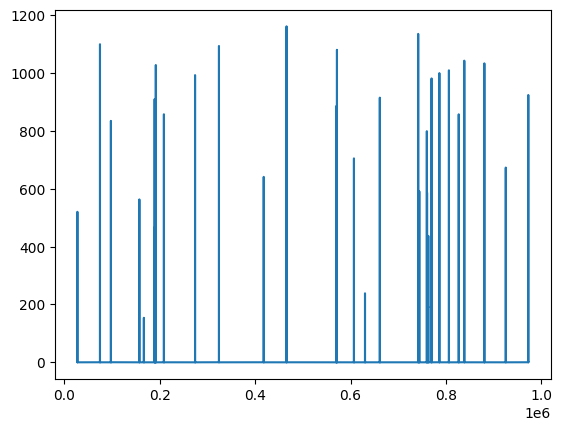

In [30]:
appendedDf.loc[appendedDf.ind_customer_id == 1].y_prod.plot()